# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
## Import all libraries
import pickle
import matplotlib.image as mpimg
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from random import randint
import csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from datetime import datetime
import os
from os import listdir


In [2]:
## Load pickled data

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print(train.keys())
print(train['features'].shape)
print(train['labels'].shape)
print(train['sizes'].shape)


dict_keys(['sizes', 'labels', 'coords', 'features'])
(39209, 32, 32, 3)
(39209,)
(39209, 2)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
## Check data set size

# Number of training examples
n_train = train['features'].shape[0]

# Number of testing examples.
n_test = test['features'].shape[0]

# Traffic sign image shape
image_shape = train['features'][0].shape

# Number of classes
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

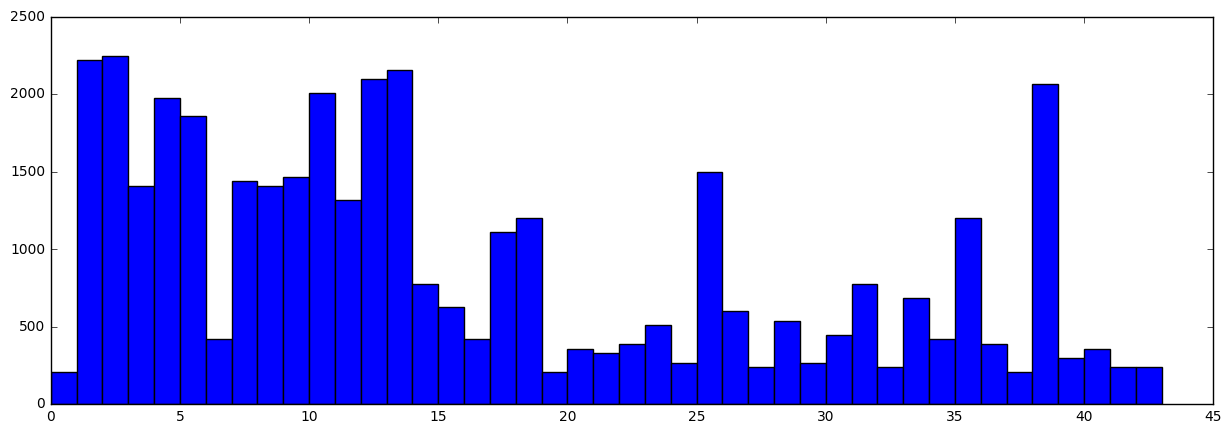

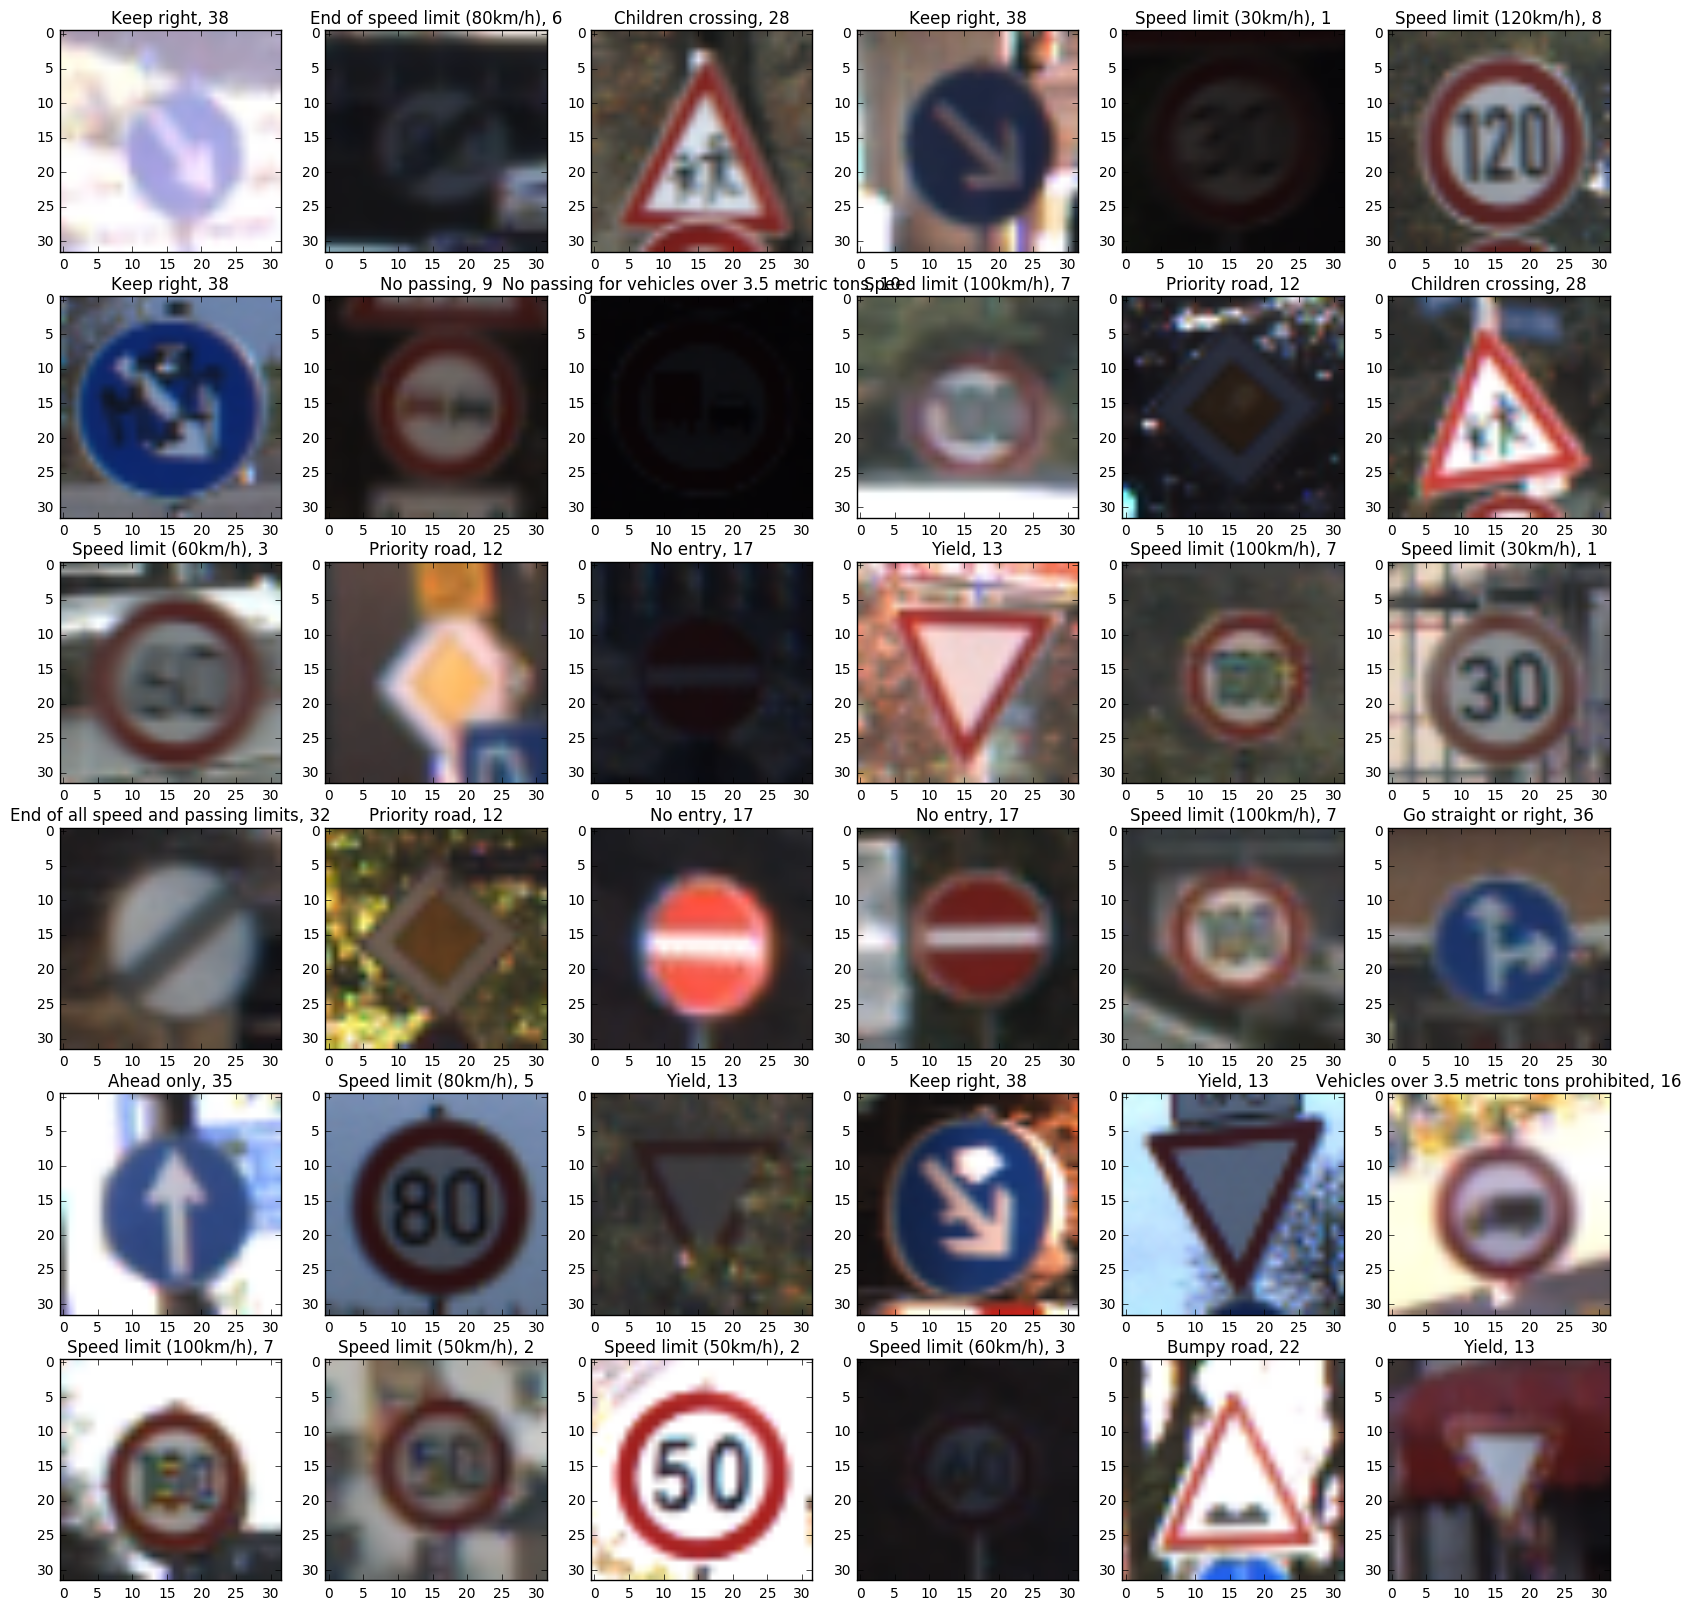

In [4]:
## Visualize data

# Visualizations will be shown in the notebook.
%matplotlib inline

# Show class distribution in bar chart
bar_chart_y = [] 
bar_chart_x = range(n_classes)
for i in range(n_classes):
    label_count = 0
    for j in range(n_train):
        if (train['labels'][j] == i):
            label_count += 1
    bar_chart_y.append(label_count)
plt.figure(figsize=(15,5))
plt.bar(bar_chart_x, bar_chart_y, 1, color="blue")
        
# Save label names in "signs"
signs = []
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

# Plot random set of data
plt.figure(figsize=(20,20))
for i in range(36):
    sub = plt.subplot(6,6,i+1)
    rand = randint(0, n_train)
    plt.imshow(train['features'][rand])
    sub.set_title("%s, %s" % (signs[train['labels'][rand]], train['labels'][rand]))
    


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
## Data preprocessing

# Shuffle data
X_train, y_train = shuffle(X_train, y_train)

#X_train = X_train.astype('float')
#batch_size = 1000
#for offset in range(0, len(y_train), batch_size):
#    # scale image data to [-1,1]
#    X_train[offset:offset+batch_size] = (X_train[offset:offset+batch_size] - 128.)/128.
#    # Mean substraction
#    X_train[offset:offset+batch_size] -= np.mean(X_train[offset:offset+batch_size], axis = 0)
#    # Normalization
#    X_train[offset:offset+batch_size] /= np.std(X_train[offset:offset+batch_size], axis = 0)

#X_test = (X_test.astype('float') - 128.)/128.
#X_test -= np.mean (X_train, axis=0)
#X_test /= np.std(X_train, axis=0)



### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
The data was shuffled so in each batch we ideally have all traffic signs represented. A mean substraction and normalization was tested, but it did not perform well on the network, so these steps were commented out. They also had to be performed in batches due to memory constraints.

In [6]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42)

print ("training data set: ", train_features.shape)
print ("validation data set: ", valid_features.shape)

training data set:  (31367, 32, 32, 3)
validation data set:  (7842, 32, 32, 3)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

The data was split to 80% training data and 20% validation data.

In [7]:
## Definition of LeNet architecture and Hyperparameters
tf.reset_default_graph()

with tf.name_scope("weights"):
    weights = {
        'conv1':tf.Variable(tf.truncated_normal([5,5,3,70], stddev=0.01),name='weight_conv1'),
        'conv2':tf.Variable(tf.truncated_normal([5,5,70,70], stddev=0.01),name='weight_conv2'),
        'fully1':tf.Variable(tf.truncated_normal([1750, 1200], stddev=0.01),name='weight_fully1'),
        'fully2':tf.Variable(tf.truncated_normal([1200,1000], stddev=0.01),name='weight_fully2'),
        'out':tf.Variable(tf.truncated_normal([1000,43], stddev=0.01),name='weight_out'),
    }
    
with tf.name_scope("biases"):
    biases = {
        'conv1':tf.Variable(tf.zeros(70),name='bias_conv1'),
        'conv2':tf.Variable(tf.zeros(70),name='bias_conv2'),
        'fully1':tf.Variable(tf.zeros(1200),name='bias_fully1'),
        'fully2':tf.Variable(tf.zeros(1000),name='bias_fully2'),
        'out':tf.Variable(tf.zeros(43),name='bias_out')
    }

def LeNet(x):
    
    with tf.name_scope('conv1'):
        conv1 = tf.nn.conv2d(x,weights['conv1'],[1,1,1,1],'VALID')
        conv1 = tf.nn.bias_add(conv1, biases['conv1'])
        print("Convolution", conv1.get_shape())                       
        conv1 = tf.nn.relu(conv1)

        conv1 = tf.nn.max_pool(conv1,[1,2,2,1],[1,2,2,1],'SAME')
        print("Pooling", conv1.get_shape())
        conv1 = tf.nn.dropout(conv1,keep_prob)
    
    with tf.name_scope('conv2'):
        conv2 = tf.nn.conv2d(conv1,weights['conv2'],[1,1,1,1],'VALID')
        conv2 = tf.nn.bias_add(conv2, biases['conv2'])
        print("Convolution",conv2.get_shape())                         

        conv2 = tf.nn.relu(conv2)
        conv2 = tf.nn.dropout(conv2,keep_prob)

        conv2 = tf.nn.max_pool(conv2,[1,2,2,1],[1,2,2,1],'SAME')
        print("Pooling",conv2.get_shape())  

        conv2 = flatten(conv2)
        print("Flattened conv2", conv2.get_shape())
    
    with tf.name_scope('fully1'):
        fully1 = tf.add(tf.matmul(conv2,weights['fully1']),biases['fully1'])
        print("Fully1", fully1.get_shape())                         

        fully1 = tf.nn.relu(fully1)
        fully1 = tf.nn.dropout(fully1,keep_prob)

    with tf.name_scope('fully2'):
        fully2 = tf.add(tf.matmul(fully1,weights['fully2']),biases['fully2'])

        fully2 = tf.nn.relu(fully2)
        fully2 = tf.nn.dropout(fully2,keep_prob)
    
    with tf.name_scope('logits'):
        logits = tf.add(tf.matmul(fully2,weights['out']),biases['out'])
                            
    return logits

with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, (None, 32, 32, 3))
    y = tf.placeholder(tf.int32, (None))
    keep_prob = tf.placeholder(tf.float32)
    
one_hot_y = tf.one_hot(y, 43)

rate = 0.001 #0.00005
EPOCHS = 2
BATCH_SIZE = 200
keep_probability = 0.5
beta = 0.01

logits = LeNet(x)

with tf.name_scope('training_operation'):
    regularizer = tf.nn.l2_loss(weights['conv1']) \
        + tf.nn.l2_loss(weights['conv2']) \
        + tf.nn.l2_loss(weights['fully1']) \
        + tf.nn.l2_loss(weights['fully2']) \
        + tf.nn.l2_loss(weights['out'])

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
    loss_operation = tf.reduce_mean(cross_entropy + beta * regularizer)
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    training_operation = optimizer.minimize(loss_operation)

with tf.name_scope('prediction'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Convolution (?, 28, 28, 70)
Pooling (?, 14, 14, 70)
Convolution (?, 10, 10, 70)
Pooling (?, 5, 5, 70)
Flattened conv2 (?, 1750)
Fully1 (?, 1200)


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My final architecture is a simple LeNet with dropout in all hidden layers. All layers feed into the next layer without skipping. 60 filters per convolutional layer performed well for this task which is discussed below in more detail.
- Convolution
- Pooling
- Convolution
- Pooling
- Fully Connected
- Fully Connected
- Output


In [9]:
### Train your model here.
### Feel free to use as many code cells as needed.

#tensorboard --logdir=run1:./log/1,run2:./log/2 --port=6006
logs_path = './log/2'
tf.summary.scalar("loss", loss_operation)
tf.summary.scalar("accuracy", accuracy_operation)
summary_op = tf.summary.merge_all()
startTime = datetime.now()  

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(train_features)

    print("Training...")
    print()
    for i in range(EPOCHS):
        
        writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
        
        batch_count = int(num_examples/BATCH_SIZE)
        train_features, train_labels = shuffle(train_features, train_labels)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, summary = sess.run([training_operation,summary_op], feed_dict={x: batch_x, y: batch_y, keep_prob:keep_probability})
            
            writer.add_summary(summary,i * num_examples + offset)
        
        validation_accuracy = evaluate(valid_features, valid_labels)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    test_accuracy = 0
    test_accuracy = evaluate(X_test,y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, './lenet')
    print("Model saved")
    print()

print("Time taken:", datetime.now() - startTime)


Training...

EPOCH 1 ...
Validation Accuracy = 0.592

EPOCH 2 ...
Validation Accuracy = 0.834

Test Accuracy = 0.791
Model saved

Time taken: 0:02:05.020333


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
The Adam Optimizer as default worked well, so there was no need for change. I chose the batch size around 500 but 200-1000 were all acceptable. Depending of the convolutional depths the batch size had to be reduced because I am restricted to 4 GB of RAM. Usually it took about 10 epochs before the validation accuracy converged. A dropout about 50% reduces overfitting. A L2-regulization further prevents the network to get conditioned badly.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
I started with the LeNet architecture from the MNIST dataset. My first mistake was that I used the default standard deviation of the truncated_normal function. This made my network bad conditioned from the very beginning. I could reach above 60 percent validation accuracy. My interpretation was that if my network can't even fit the validation set, it must be underfitting. So I increased the depth of the network until I had four convolutional layers and faced training time of 45 minutes. The amount of parameters were to high.

After setting std_dev to 0.01 the network behaved very much better. So I went back to the initial LeNet. With some testing I found out that the fully connected layers must be one order of magnitude larger to give it enough capacity for reasoning. Furthermore increasing the features to 100 in each convolutional layer performed well with dropout. On the other hand a dropout is not compatible with a low set of features like 30. I have also tested the architecure which was suggested in a paper. The first convolutional layer was also fed into the fully connected layer. But due to memory constraints, I had to limit the number of features which in the end reduced it performance.

As a result the standard LeNet worked very well for that problem. For the learning rate, I started with the recommended 0.001 but found it to be too fast and reduced it to 0.00025.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
############## DO NOT RUN THIS CODE ################
############## DO NOT RUN THIS CODE ################
############## DO NOT RUN THIS CODE ################

## Saving new images to pickle file.
## The images are handlabeled
## The order of the images is not guaranteed to be the same
## I should sort by file name but I didn't

%matplotlib inline

image_file_paths = listdir('test_images')

images = []
for path in image_file_paths:
    images.append(mpimg.imread('%s%s' % ('test_images/', path)))
    
new_signs_img = np.zeros([len(images),32,32,3],dtype=np.uint8)
new_signs_label = np.array([28,2,22,22,36,
                            13,17,1,1,17,
                            25,38,25,31,35,
                            22,25,36,38,38,
                            17,22,35,12,33,
                            38,38,25,38
                           ],dtype=np.uint8)

with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

plt.figure(figsize=(20,20))
for id,img in enumerate(images):
    images[id] = cv2.resize(img,dsize=(32,32))
    new_signs_img[id] = images[id]
    sub = plt.subplot(6,5,id+1)
    plt.imshow(new_signs_img[id])
    sub.set_title("%s, %s" % (signs[new_signs_label[id]], new_signs_label[id]))

pickle_file = 'new_signs.p'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('new_signs.p', 'wb') as pfile:
            pickle.dump(
                {
                    'data': new_signs_img,
                    'labels': new_signs_label,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

############## DO NOT RUN THIS CODE ################
############## DO NOT RUN THIS CODE ################
############## DO NOT RUN THIS CODE ################

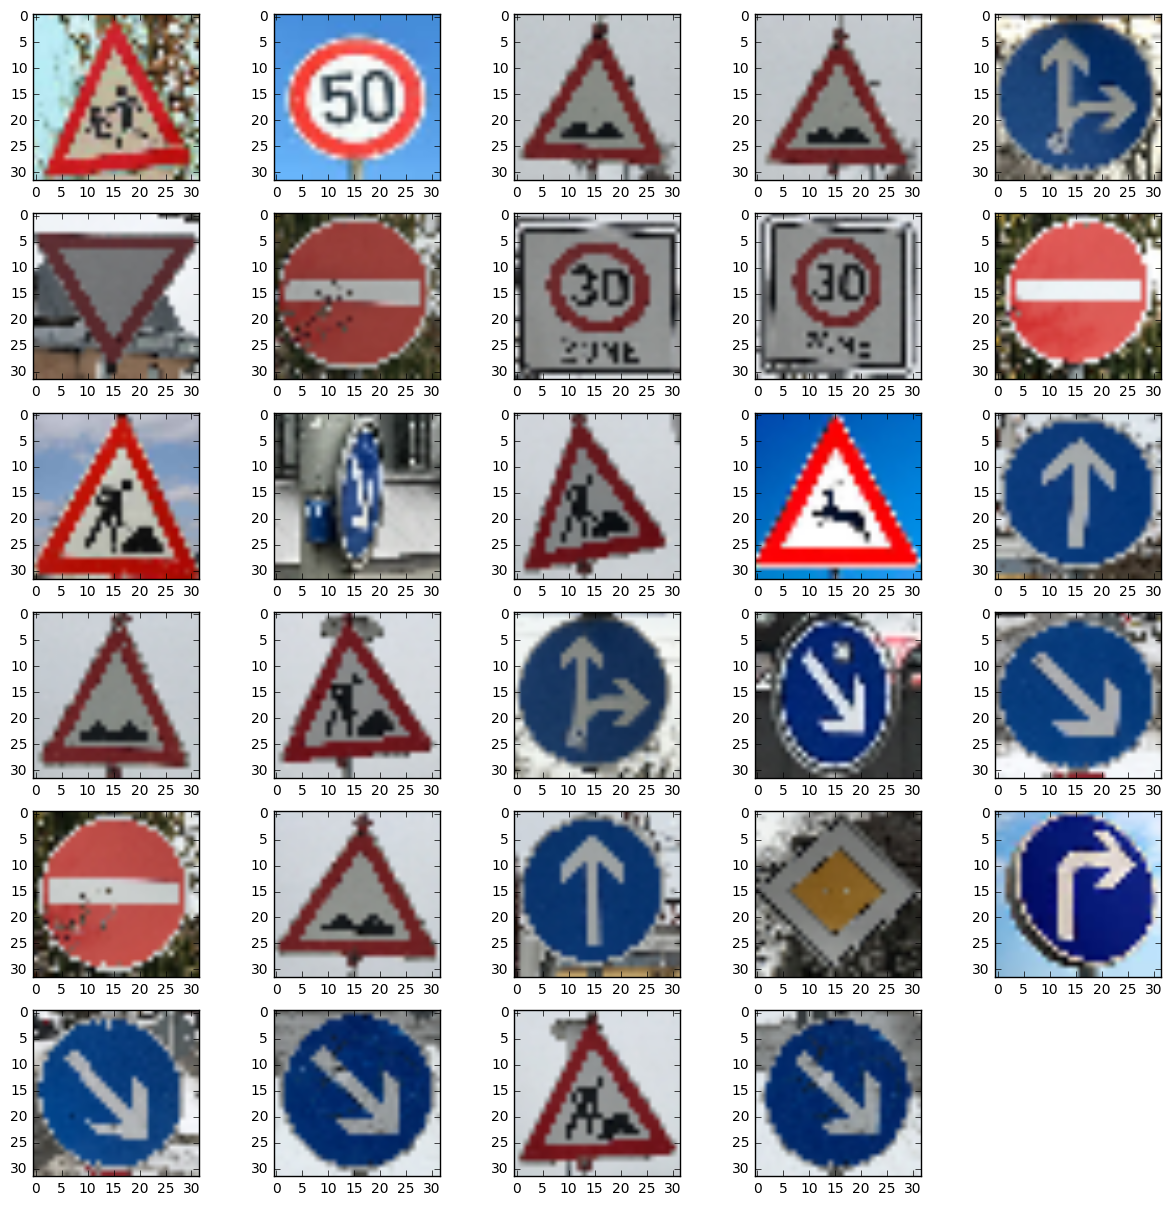

In [10]:
## Load new images from pickle file

%matplotlib inline

new_signs_file = "new_signs.p"

with open(new_signs_file, mode='rb') as f:
    new_signs = pickle.load(f)
    f.close()

X_new = new_signs['data']
y_new = new_signs['labels']

plt.figure(figsize=(15,15))
for i in range(y_new.size):
    plt.subplot(6,5,i+1)
    plt.imshow(X_new[i])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
I took some pictures around my town. There are some pictures which could be difficult.
One picture I took from the side, most training data show the frontal, it might not be recognized.
The 30 speed limit is a little bit different than usual. It has the word 'Zone' in it which is also not represented in the training set. A stop sign has some branches in front of it.

In [11]:
## Run the predictions

saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    test_accuracy = sess.run(accuracy_operation, feed_dict={x: X_new, y: y_new, keep_prob:1})

    print("Test Accuracy = {:.3f}".format(test_accuracy))


Test Accuracy = 0.862


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
The accuracy is very high on the easy images. Tree branches and scribblings on signs or not a problem. Only big deviations from the dataset are not generalized. It also seems that my network is not quite invariant to translation. The 30 speed limit seems to be an easy task but it is recognized with low certainty which is shown below.

In [26]:
top_3[1][1][:]

array([1, 2, 7], dtype=int32)

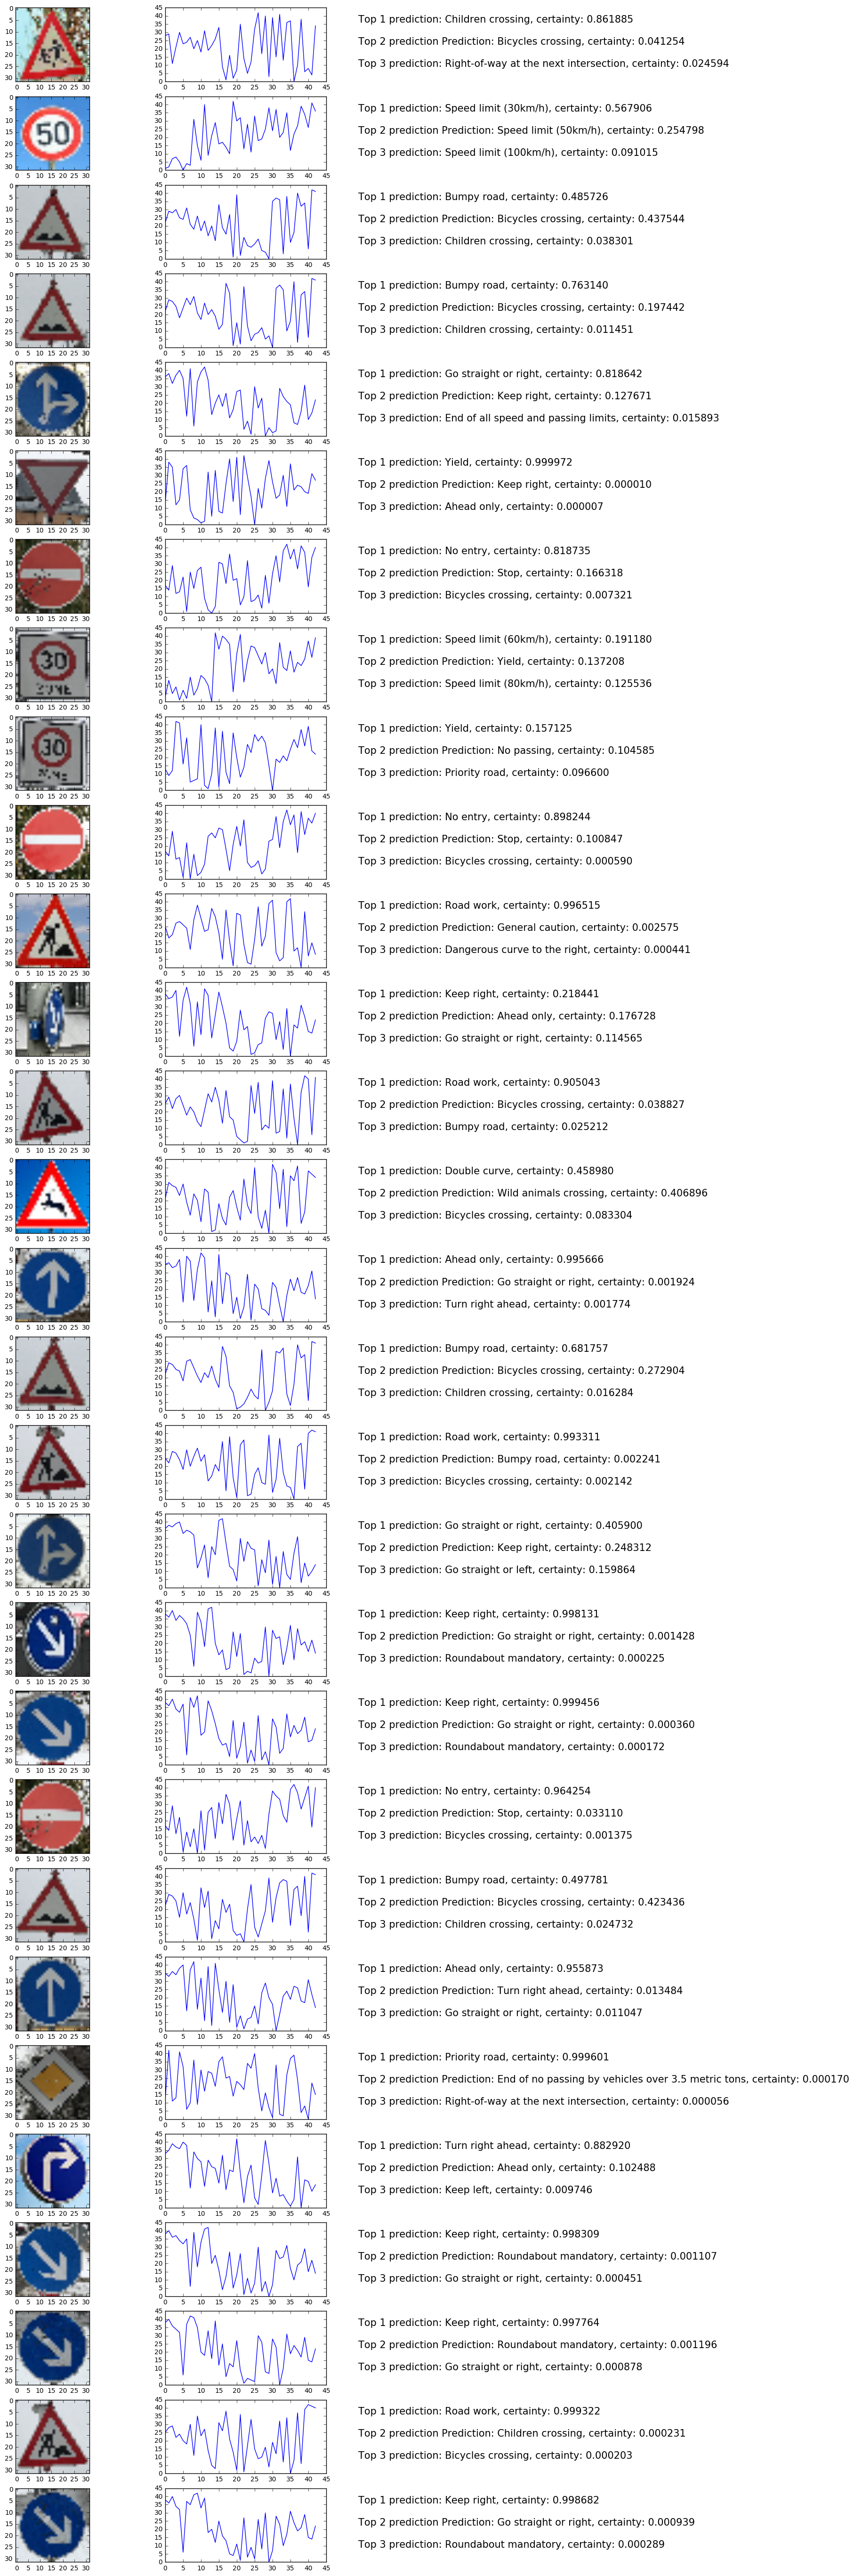

In [46]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
signs = []
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()
saver = tf.train.Saver()

softmax = tf.nn.softmax(logits)
top_43_op = tf.nn.top_k(softmax,43) # Structure: [Prediction/Certainty][image][top]
top_3_op = tf.nn.top_k(softmax,3)

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    top_3, top_43 = sess.run([top_3_op, top_43_op], feed_dict={x: X_new, y: y_new, keep_prob:1})

plt.figure(figsize=(15,70))
for i in range(y_new.size):
    plt.subplot(y_new.size,3,i*3+1)
    plt.imshow(X_new[i])
    
    plt.subplot(y_new.size,3,i*3+2)
    plt.plot(list(range(43)),top_43[1][i][:])
    
    sub = plt.subplot(y_new.size,3,i*3+3)
    plt.axis('off')
    sub.text(0, 0.8, 'Top 1 prediction: %s, certainty: %f' % (signs[top_3[1][i][0]], top_3[0][i][0]),fontsize=15)
    sub.text(0, 0.5, 'Top 2 prediction Prediction: %s, certainty: %f' % (signs[top_3[1][i][1]], top_3[0][i][1]),fontsize=15)
    sub.text(0, 0.2, 'Top 3 prediction: %s, certainty: %f' % (signs[top_3[1][i][2]], top_3[0][i][2]),fontsize=15)
    
    #sub.set_title("Prediction: %s, Certainty: %f" % (signs[top_3[1][i][0]], top_3[0][i][0]))

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
As we can see, the certainty depends on the deviation of the training set. But mostly the class with the highest certainty is still correct.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.